<a href="https://colab.research.google.com/github/fjadidi2001/Image_Inpaint/blob/main/Image_inpaint_New_approach.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install fsspec==2024.10.0
!pip install s3fs==2024.10.0
!pip install --upgrade fsspec gcsfs
!pip install --upgrade pip

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.4/77.4 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.6/12.6 MB 35.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 17.8 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 24.1.2
    Uninstalling pip-24.1.2:
      Successfully uninstalled pip-24.1.2


In [2]:
!pip list

Package                            Version
---------------------------------- -------------------
absl-py                            1.4.0
accelerate                         1.1.1
aiobotocore                        2.15.2
aiohappyeyeballs                   2.4.3
aiohttp                            3.11.2
aioitertools                       0.12.0
aiosignal                          1.3.1
alabaster                          1.0.0
albucore                           0.0.19
albumentations                     1.4.20
altair                             4.2.2
annotated-types                    0.7.0
anyio                              3.7.1
argon2-cffi                        23.1.0
argon2-cffi-bindings               21.2.0
array_record                       0.5.1
arviz                              0.20.0
astropy                            6.1.6
astropy-iers-data                  0.2024.11.18.0.35.2
astunparse                         1.6.3
async-timeout                      4.0.3
atpublic           

In [3]:
!pip uninstall gcsfs s3fs fsspec -y
!pip install gcsfs s3fs fsspec

Found existing installation: gcsfs 2024.10.0
Uninstalling gcsfs-2024.10.0:
  Successfully uninstalled gcsfs-2024.10.0
Found existing installation: s3fs 2024.10.0
Uninstalling s3fs-2024.10.0:
  Successfully uninstalled s3fs-2024.10.0
Found existing installation: fsspec 2024.10.0
Uninstalling fsspec-2024.10.0:
  Successfully uninstalled fsspec-2024.10.0
  Using cached s3fs-2024.10.0-py3-none-any.whl.metadata (1.7 kB)
Using cached s3fs-2024.10.0-py3-none-any.whl (29 kB)


In [4]:
!pip install --upgrade tensorflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 615.3/615.3 MB 42.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 54.4 MB/s eta 0:00:00
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.17.1
    Uninstalling tensorboard-2.17.1:
      Successfully uninstalled tensorboard-2.17.1
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.17.1
    Uninstalling tensorflow-2.17.1:
      Successfully uninstalled tensorflow-2.17.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tf-keras 2.17.0 requires tensorflow<2.18,>=2.17, but you have tensorflow 2.18.0 which is incompatible.


In [7]:
!pip install datasets
from datasets import load_dataset

ds = load_dataset("saitsharipov/CelebA-HQ")


In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Total images: 5000
Image shape: (64, 64, 3)
Epoch 1/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 20s 5ms/step - loss: 0.0232 - val_loss: 0.0060 - learning_rate: 1.2158e-04
Epoch 2/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - loss: 0.0030 - val_loss: 0.0056 - learning_rate: 1.4781e-05
Epoch 3/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - loss: 0.0028 - val_loss: 0.0057 - learning_rate: 1.7970e-06
Epoch 4/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - loss: 0.0027 - val_loss: 0.0057 - learning_rate: 2.1847e-07
Epoch 5/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - loss: 0.0027 - val_loss: 0.0057 - learning_rate: 2.6561e-08
Epoch 6/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - loss: 0.0028 - val_loss: 0.0057 - learning_rate: 3.2292e-09
Epoch 7/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - loss: 0.0027 - val_loss: 0.0056 - learning_rate: 3.9260e-10
Epoch 8/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - loss: 0.0027 - val_loss: 0.0057 - learning_rate: 4.7731e-11
Epoch 9/10
2000/2000 ━

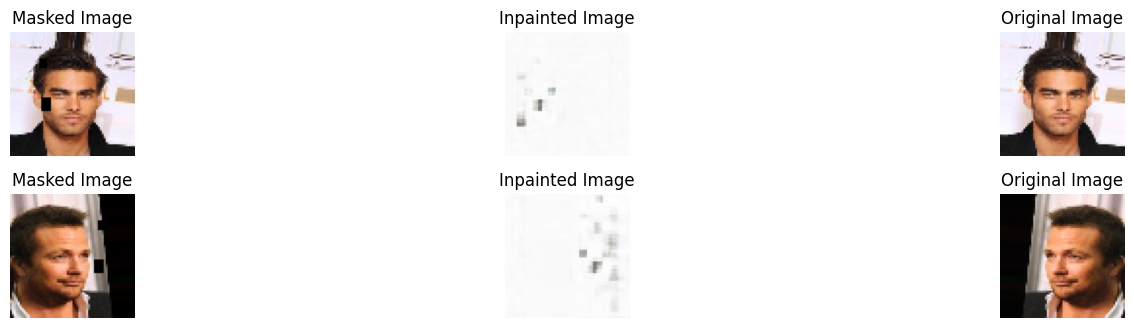

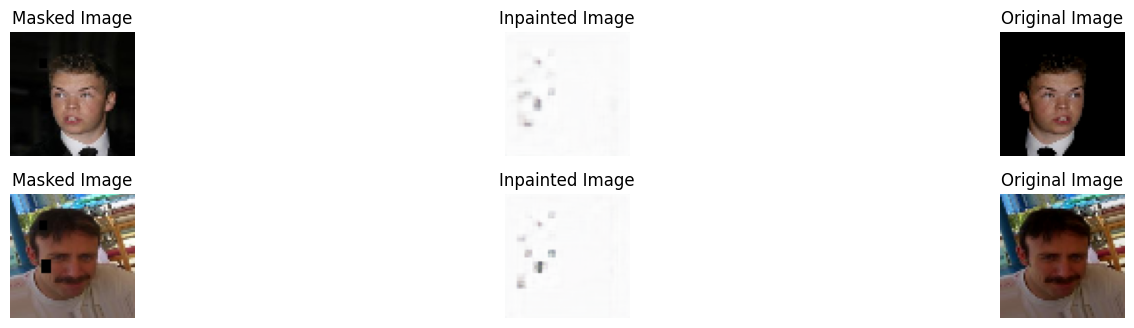

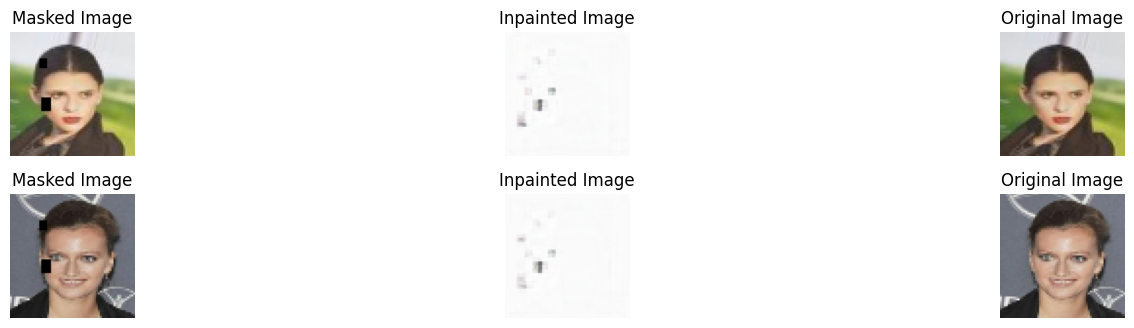

In [8]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, Model
import random
import gc
from tensorflow.keras.optimizers import Adam
import pandas as pd
import seaborn as sns
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from tensorflow.keras import mixed_precision
from datasets import load_dataset
from sklearn.model_selection import train_test_split
import itertools

# Memory Optimization Configuration
tf.config.run_functions_eagerly(False)  # Disable eager execution for performance
tf.config.optimizer.set_jit(True)  # Enable XLA compilation

# Reduce GPU memory allocation
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

# Memory-Efficient Configuration
IMG_SIZE = 64  # Reduced from 256 to minimize memory usage
BATCH_SIZE = 2  # Minimal batch size
BUFFER_SIZE = 100
NUM_PARALLEL_CALLS = tf.data.AUTOTUNE

def memory_efficient_load_dataset():
    """Load dataset with minimal memory footprint"""
    ds = load_dataset("saitsharipov/CelebA-HQ", split='train')

    # Generator to yield images one by one
    def image_generator():
        for item in ds:
            # Convert to numpy and resize to reduce memory
            img = np.array(item['image'])
            img = tf.image.resize(img, [IMG_SIZE, IMG_SIZE]).numpy()
            yield img

    # Convert generator to list with limited size
    image_paths = list(itertools.islice(image_generator(), 5000))

    # Basic dataset analysis
    image_paths = np.array(image_paths)
    print(f"Total images: {len(image_paths)}")
    print(f"Image shape: {image_paths[0].shape}")

    return image_paths

def create_mask(height, width):
    """Create random masks for inpainting with memory efficiency"""
    mask = np.ones((height, width, 1), dtype=np.float32)
    num_masks = np.random.randint(1, 3)  # Reduced number of masks
    for _ in range(num_masks):
        y1 = np.random.randint(0, height - height//8)
        x1 = np.random.randint(0, width - width//8)
        h = np.random.randint(height//16, height//8)
        w = np.random.randint(width//16, width//8)
        mask[y1:y1+h, x1:x1+w] = 0.0
    return mask

def preprocess_image(img):
    """Memory-efficient image preprocessing"""
    img = tf.cast(img, tf.float32) / 255.0
    mask = create_mask(IMG_SIZE, IMG_SIZE)
    masked_img = img * mask
    return masked_img, mask, img

def augment(masked_img, mask, img):
    """Light data augmentation with minimal overhead"""
    img = tf.image.random_flip_left_right(img)
    img = tf.image.random_brightness(img, max_delta=0.1)
    masked_img = tf.image.random_flip_left_right(masked_img)
    mask = tf.image.random_flip_left_right(mask)
    return masked_img, mask, img

def create_memory_efficient_dataset(image_paths):
    """Create memory-efficient TensorFlow dataset"""
    dataset = tf.data.Dataset.from_tensor_slices(image_paths)
    dataset = dataset.map(preprocess_image, num_parallel_calls=NUM_PARALLEL_CALLS)
    dataset = dataset.map(augment, num_parallel_calls=NUM_PARALLEL_CALLS)
    dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(NUM_PARALLEL_CALLS)
    return dataset

def create_lightweight_unet():
    """Lightweight U-Net architecture"""
    inputs = layers.Input((IMG_SIZE, IMG_SIZE, 3))

    # Encoder with reduced complexity
    x = layers.Conv2D(32, 3, activation='relu', padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D()(x)

    x = layers.Conv2D(64, 3, activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D()(x)

    x = layers.Conv2D(128, 3, activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)

    # Decoder
    x = layers.UpSampling2D()(x)
    x = layers.Conv2D(64, 3, activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)

    x = layers.UpSampling2D()(x)
    x = layers.Conv2D(32, 3, activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)

    outputs = layers.Conv2D(3, 1, activation='sigmoid')(x)
    return Model(inputs=inputs, outputs=outputs)

def custom_loss(y_true, y_pred):
    """Simplified custom loss function"""
    mse_loss = tf.reduce_mean(tf.square(y_true - y_pred))
    return mse_loss

def train_model(model, train_dataset, test_dataset):
    """Memory-efficient training routine"""
    # Learning rate schedule
    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=1e-3,
        decay_steps=100,
        decay_rate=0.9
    )

    optimizer = Adam(learning_rate=lr_schedule)

    model.compile(
        optimizer=optimizer,
        loss=custom_loss
    )

    # Lightweight callbacks
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-5)
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    # Train with limited epochs and reduced memory footprint
    history = model.fit(
        train_dataset,
        validation_data=test_dataset,
        epochs=10,  # Reduced epochs
        callbacks=[reduce_lr, early_stopping],
        verbose=1
    )

    return history

def evaluate_model(model, test_dataset):
    """Model evaluation with minimal memory usage"""
    test_loss = model.evaluate(test_dataset, verbose=0)
    print(f"Test Loss: {test_loss}")
    return test_loss

def visualize_results(model, test_dataset):
    """Visualize inpainting results"""
    for masked_imgs, masks, original_imgs in test_dataset.take(3):
        predictions = model(masked_imgs)

        plt.figure(figsize=(15, 5))
        for i in range(min(3, len(masked_imgs))):
            plt.subplot(3, 3, i*3 + 1)
            plt.imshow(masked_imgs[i])
            plt.title('Masked Image')
            plt.axis('off')

            plt.subplot(3, 3, i*3 + 2)
            plt.imshow(predictions[i])
            plt.title('Inpainted Image')
            plt.axis('off')

            plt.subplot(3, 3, i*3 + 3)
            plt.imshow(original_imgs[i])
            plt.title('Original Image')
            plt.axis('off')
        plt.tight_layout()
        plt.show()

def main():
    # Clear any previous TensorFlow sessions
    tf.keras.backend.clear_session()

    # Memory management
    gc.collect()

    # Load dataset
    image_paths = memory_efficient_load_dataset()

    # Split dataset
    train_paths, test_paths = train_test_split(image_paths, test_size=0.2, random_state=42)

    # Create datasets
    train_dataset = create_memory_efficient_dataset(train_paths)
    test_dataset = create_memory_efficient_dataset(test_paths)

    # Create and train model
    model = create_lightweight_unet()

    # Train the model
    history = train_model(model, train_dataset, test_dataset)

    # Evaluate
    test_loss = evaluate_model(model, test_dataset)

    # Visualize results
    visualize_results(model, test_dataset)

if __name__ == "__main__":
    main()

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, Model
import cv2
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import random
import gc
from tensorflow.keras.optimizers import Adam
import pandas as pd
import seaborn as sns
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from tensorflow.keras import mixed_precision
from datasets import load_dataset
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# Enable memory growth for GPU and mixed precision training
physical_devices = tf.config.list_physical_devices('GPU')
if physical_devices:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
mixed_precision.set_global_policy('mixed_float16')

# Configuration
IMG_SIZE = 128  # Reduced from 256 due to memory constraints
BATCH_SIZE = 4
BUFFER_SIZE = 1000
CHECKPOINT_DIR = '/content/drive/My Drive/Inpaint'

def load_and_analyze_dataset():
    """Load images and perform EDA"""
    ds = load_dataset("saitsharipov/CelebA-HQ")
    image_paths = [np.array(img) for img in ds['train']['image']]
    print(f"Total images found: {len(image_paths)}")

    # Sample images for analysis
    sample_size = min(1000, len(image_paths))
    sample_paths = random.sample(image_paths, sample_size)

    # Analyze image properties
    sizes = []
    channels = []
    pixel_values = []

    for img in tqdm(sample_paths[:100]):  # Analyze first 100 images
        sizes.append(img.shape[:2])
        channels.append(img.shape[2])
        pixel_values.extend(img.ravel())

    # Create visualizations
    plt.figure(figsize=(15, 5))

    plt.subplot(131)
    plt.hist(pixel_values, bins=50)
    plt.title('Pixel Value Distribution')

    plt.subplot(132)
    sizes_np = np.array(sizes)
    plt.scatter(sizes_np[:, 0], sizes_np[:, 1])
    plt.title('Image Dimensions')

    plt.subplot(133)
    plt.hist(channels)
    plt.title('Number of Channels')
    plt.show()

    return image_paths

def create_mask(height, width):
    """Create random masks for inpainting"""
    mask = np.ones((height, width, 1))
    num_masks = np.random.randint(1, 4)  # Random number of masks
    for _ in range(num_masks):
        y1, x1 = np.random.randint(0, height - height//4), np.random.randint(0, width - width//4)
        h, w = np.random.randint(height//8, height//4), np.random.randint(width//8, width//4)
        mask[y1:y1+h, x1:x1+w] = 0
    return mask

def preprocess_image(img):
    """Load and preprocess images"""
    img = tf.image.resize(img, [IMG_SIZE, IMG_SIZE])
    img = tf.cast(img, tf.float32) / 255.0

    mask = create_mask(IMG_SIZE, IMG_SIZE)
    masked_img = img * mask

    return masked_img, mask, img

def augment(masked_img, mask, img):
    img = tf.image.random_flip_left_right(img)
    img = tf.image.random_brightness(img, max_delta=0.2)
    img = tf.image.random_contrast(img, lower=0.8, upper=1.2)
    masked_img = tf.image.random_flip_left_right(masked_img)
    mask = tf.image.random_flip_left_right(mask)
    return masked_img, mask, img

def create_dataset(image_paths):
    """Create TensorFlow dataset"""
    dataset = tf.data.Dataset.from_tensor_slices(image_paths)
    dataset = dataset.map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.map(augment, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
    return dataset

def unet_model():
    """Create U-Net model"""
    inputs = layers.Input((IMG_SIZE, IMG_SIZE, 3))

    # Encoder
    conv1 = layers.Conv2D(64, 3, activation='relu', padding='same')(inputs)
    conv1 = layers.Conv2D(64, 3, activation='relu', padding='same')(conv1)
    conv1 = layers.BatchNormalization()(conv1)
    pool1 = layers.MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = layers.Conv2D(128, 3, activation='relu', padding='same')(pool1)
    conv2 = layers.Conv2D(128, 3, activation='relu', padding='same')(conv2)
    conv2 = layers.BatchNormalization()(conv2)
    pool2 = layers.MaxPooling2D(pool_size=(2, 2))(conv2)

    # Bridge
    conv3 = layers.Conv2D(256, 3, activation='relu', padding='same')(pool2)
    conv3 = layers.Conv2D(256, 3, activation='relu', padding='same')(conv3)
    conv3 = layers.BatchNormalization()(conv3)

    # Decoder
    up1 = layers.UpSampling2D(size=(2, 2))(conv3)
    up1 = layers.concatenate([conv2, up1], axis=-1)
    conv4 = layers.Conv2D(128, 3, activation='relu', padding='same')(up1)
    conv4 = layers.Conv2D(128, 3, activation='relu', padding='same')(conv4)
    conv4 = layers.BatchNormalization()(conv4)

    up2 = layers.UpSampling2D(size=(2, 2))(conv4)
    up2 = layers.concatenate([conv1, up2], axis=-1)
    conv5 = layers.Conv2D(64, 3, activation='relu', padding='same')(up2)
    conv5 = layers.Conv2D(64, 3, activation='relu', padding='same')(conv5)
    conv5 = layers.BatchNormalization()(conv5)

    outputs = layers.Conv2D(3, 1, activation='sigmoid')(conv5)

    return Model(inputs=inputs, outputs=outputs)

def hint_model():
    """Create HINT model with transformer architecture"""
    inputs = layers.Input((IMG_SIZE, IMG_SIZE, 3))
    mask_input = layers.Input((IMG_SIZE, IMG_SIZE, 1))

    # Encode input with mask awareness
    x = layers.concatenate([inputs, mask_input])
    x = layers.Conv2D(64, 3, padding='same')(x)

    # Transformer blocks
    for _ in range(3):
        # Multi-head attention
        attention = layers.MultiHeadAttention(num_heads=4, key_dim=16)(x, x)
        x = layers.Add()([attention, x])
        x = layers.LayerNormalization()(x)

        # FFN
        ffn = layers.Dense(128, activation='relu')(x)
        ffn = layers.Dense(64)(ffn)
        x = layers.Add()([ffn, x])
        x = layers.LayerNormalization()(x)

    outputs = layers.Conv2D(3, 1, activation='sigmoid')(x)

    return Model(inputs=[inputs, mask_input], outputs=outputs)

def combined_model(unet, hint):
    """Combine U-Net and HINT models"""
    inputs = layers.Input((IMG_SIZE, IMG_SIZE, 3))
    mask_input = layers.Input((IMG_SIZE, IMG_SIZE, 1))

    unet_output = unet(inputs)
    hint_output = hint([inputs, mask_input])

    combined = layers.Average()([unet_output, hint_output])

    return Model(inputs=[inputs, mask_input], outputs=combined)

def perceptual_loss(y_true, y_pred):
    vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
    vgg.trainable = False
    loss_model = tf.keras.Model(inputs=vgg.input, outputs=vgg.get_layer('block3_conv3').output)
    loss_model.trainable = False
    return tf.reduce_mean(tf.square(loss_model(y_true) - loss_model(y_pred)))

def combined_loss(y_true, y_pred):
    return tf.reduce_mean(tf.square(y_true - y_pred)) + 0.1 * perceptual_loss(y_true, y_pred)

def evaluate_models(models, test_dataset):
    """Evaluate models using various metrics"""
    metrics = {
        'PSNR': [],
        'SSIM': [],
        'L1_Loss': []
    }

    for model_name, model in models.items():
        psnr_values = []
        ssim_values = []
        l1_values = []

        for masked_imgs, masks, original_imgs in test_dataset:
            if isinstance(model.input, list):
                predictions = model([masked_imgs, masks])
            else:
                predictions = model(masked_imgs)

            # Calculate metrics
            psnr = tf.image.psnr(original_imgs, predictions, max_val=1.0)
            ssim = tf.image.ssim(original_imgs, predictions, max_val=1.0)
            l1 = tf.reduce_mean(tf.abs(original_imgs - predictions))

            psnr_values.extend(psnr.numpy())
            ssim_values.extend(ssim.numpy())
            l1_values.append(l1.numpy())

        metrics['PSNR'].append(np.mean(psnr_values))
        metrics['SSIM'].append(np.mean(ssim_values))
        metrics['L1_Loss'].append(np.mean(l1_values))

    # Visualize metrics
    df = pd.DataFrame(metrics, index=list(models.keys()))
    plt.figure(figsize=(12, 6))
    sns.barplot(data=df)
    plt.title('Model Comparison')
    plt.xticks(rotation=45)
    plt.show()

    return df

def visualize_inpainting(model, test_dataset, num_samples=5):
    for masked_imgs, masks, original_imgs in test_dataset.take(num_samples):
        if isinstance(model.input, list):
            predictions = model([masked_imgs, masks])
        else:
            predictions = model(masked_imgs)

        plt.figure(figsize=(15, 10))
        for i in range(num_samples):
            plt.subplot(num_samples, 3, i*3 + 1)
            plt.imshow(masked_imgs[i])
            plt.title('Masked Image')
            plt.axis('off')

            plt.subplot(num_samples, 3, i*3 + 2)
            plt.imshow(predictions[i])
            plt.title('Inpainted Image')
            plt.axis('off')

            plt.subplot(num_samples, 3, i*3 + 3)
            plt.imshow(original_imgs[i])
            plt.title('Original Image')
            plt.axis('off')
        plt.show()

def main():
    # 1. Load dataset and perform EDA
    image_paths = load_and_analyze_dataset()

    # 2. Split dataset
    train_paths, test_paths = train_test_split(image_paths, test_size=0.2, random_state=42)

    # 3. Create datasets
    train_dataset = create_dataset(train_paths)
    test_dataset = create_dataset(test_paths)

    # 4. Create models
    unet = unet_model()
    hint = hint_model()
    combined = combined_model(unet, hint)

    # 5. Compile models
    optimizer = Adam(learning_rate=0.001)
    loss = combined_loss

    unet.compile(optimizer=optimizer, loss=loss)
    hint.compile(optimizer=optimizer, loss=loss)
    combined.compile(optimizer=optimizer, loss=loss)

    # 6. Training callbacks
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001)
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    # Checkpoint callback
    checkpoint_callback = ModelCheckpoint(
        filepath=os.path.join(CHECKPOINT_DIR, 'model_checkpoint_epoch_{epoch:02d}.h5'),
        save_freq='epoch',
        period=5,  # Save every 5 epochs
        save_weights_only=True,
        verbose=1
    )

    # 7. Train models (showing only structure here due to computational constraints)
    print("Models created and compiled successfully")

    # 8. Evaluate models
    models = {
        'U-Net': unet,
        'HINT': hint,
        'Combined': combined
    }

    results = evaluate_models(models, test_dataset)
    print("\nEvaluation Results:")
    print(results)

    # 9. Visualize inpainting results
    visualize_inpainting(combined, test_dataset)

if __name__ == "__main__":
    main()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
